In [1]:
import ecc_tools as tools
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#import emachine as EM
from direct_info import direct_info
from direct_info import sort_di
import data_processing as dp

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

# import inference_dca for mfDCA
from inference_dca import direct_info_dca

# import pydca for plmDCA
from pydca.plmdca import plmdca
from pydca.meanfield_dca import meanfield_dca
from pydca.sequence_backmapper import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.contact_visualizer import contact_visualizer
from pydca.dca_utilities import dca_utilities

tools.hide_toggle()

# Blocky ROC curve Issue
* Enforcing distal constraint can lead to a blocky ROC curve
    * This is common in classification problems
    * Essentially you have grouped periods of TP/FP classifications
* We want to investigate what leads to this issue.

### First we will infer contact mappings without a distance constraint

In [2]:
# Read in Protein structure
data_path = '../Pfam-A.full'
pfam_id = 'PF04542'

pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))

# Pre-Process Structure Data
# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

ipdb = 0
print('seq:',int(pdb[ipdb,1]))

# Read in Sequence Data
# data processing
s0,cols_removed,s_index,s_ipdb = dp.data_processing(data_path,pfam_id,ipdb,\
                gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)
# Save processed data
msa_outfile, ref_outfile = dp.write_FASTA(s0,pfam_id,s_ipdb)

tools.hide_toggle()

number of pdb structures: 163
seq: 893
tpdb is now  861


In [3]:
#create mean-field DCA instance 
mfdca_inst = meanfield_dca.MeanFieldDCA(
    msa_outfile,
    'protein',
    pseudocount = 0.5,
    seqid = 0.8,

)

#start_time = timeit.default_timer()
#di_mf = direct_info_dca(s0)
#run_time = timeit.default_timer() - start_time
#print('MF run time:',run_time)

# Compute DCA scores using Mean Field DCA
start_time = timeit.default_timer()
sorted_DI_mf = mfdca_inst.compute_sorted_DI()
run_time = timeit.default_timer() - start_time
print('MF run time:',run_time)

N = mfdca_inst.sequences_len
B = mfdca_inst.num_sequences
print("sorted_DI (list) has shape: ",np.array(sorted_DI_mf).shape,"\nRows: all combinations of sequence postitions ie sequence len choose 2 ")
print("num sequences = %d , sequences len = %d\n\n"%(B,N))


tools.hide_toggle()

MF run time: 87.47285185198416
sorted_DI (list) has shape:  (1953, 2) 
Rows: all combinations of sequence postitions ie sequence len choose 2 
num sequences = 88414 , sequences len = 63




### We want to consider a list of sorted pairs and then enforce a distance constraint st |i-j|<5
* Loop through sorted pairs and zero scores where site pairs are too close
* Re-order
* Save both DI matrices form comparison

In [4]:
print("Print top 10 pairs")
for site_pair,score in sorted_DI_mf[:10]:
    print(site_pair,score)
    
print("\n Re-sort and Print top 10 pairs w/ Distance Restraint")
sorted_DI_mf_dr = tools.distance_restr_sortedDI(sorted_DI_mf)
for site_pair, score in sorted_DI_mf_dr[:10]:
    print(site_pair, score)

"""
Re-casting uneccessary since the visualization takes a reference sequence which is also processed (ie cols removed)
# Re-cast sorted DI pairs to original index, using s_index
#from data_processing import recast_sorted_DI(sorted_DI_mf_dr, s_index)
def recast_sorted_DI(sorted_DI_in, s_index, original_size=False):
    sorted_DI = sorted_DI_in.copy()
    for i,x in enumerate(sorted_DI):
        #print(x)
        sorted_DI[i] = ((s_index[x[0][0]],s_index[x[0][1]]),x[1])
        #print(((s_index[x[0][0]],s_index[x[0][1]]),x[1]))
    DI_mat = np.zeros((s_index[-1]+1,s_index[-1]+1))
    for coupling in sorted_DI:
        DI_mat[coupling[0][0],coupling[0][1]] = coupling[1]
        DI_mat[coupling[0][1],coupling[0][0]] = coupling[1]
    return sorted_DI, DI_mat
print('\nrecast sorted DI using s_index:\n',s_index,'\n')
sorted_DI_mf_dr_recast, di_mf_dr_recast = recast_sorted_DI(sorted_DI_mf_dr,s_index)    
for site_pair, score in sorted_DI_mf_dr_recast[:10]:
    print(site_pair, score)
"""

# Generate Direct Information matrix
di_mf = np.zeros((N,N))
di_mf_dr = np.zeros((N,N))
for coupling in sorted_DI_mf:
    di_mf[coupling[0][0],coupling[0][1]] = coupling[1]
    di_mf[coupling[0][1],coupling[0][0]] = coupling[1]
for coupling in sorted_DI_mf_dr:
    di_mf_dr[coupling[0][0],coupling[0][1]] = coupling[1]
    di_mf_dr[coupling[0][1],coupling[0][0]] = coupling[1]

print("\n\nCalculated DI: (shape, matrix)\n",di_mf.shape," di_mf[:6,:6] =\n",di_mf[:6,:6])
print("\n\nCalculated DI: (shape, matrix)\n",di_mf_dr.shape," di_mf_dr[:6,:6] =\n",di_mf_dr[:6,:6])

np.save("mfDCA_DI_%s.npy"%(pfam_id),di_mf)

tools.hide_toggle()

Print top 10 pairs
(29, 54) 0.1349360111500186
(10, 51) 0.12797077628145928
(26, 51) 0.12336779265227321
(30, 46) 0.11147875469963386
(1, 2) 0.09895280190871727
(0, 1) 0.09433463930571034
(49, 53) 0.09318300828291175
(57, 60) 0.08823648808264173
(50, 53) 0.08039613288259129
(36, 37) 0.08018999157054338

 Re-sort and Print top 10 pairs w/ Distance Restraint
(29, 54) 0.1349360111500186
(10, 51) 0.12797077628145928
(26, 51) 0.12336779265227321
(30, 46) 0.11147875469963386
(13, 55) 0.07970715024996665
(30, 47) 0.07745504831766777
(2, 27) 0.07157945223443687
(6, 23) 0.06542538089515322
(9, 48) 0.06469073384331332
(5, 44) 0.06417097310673427


Calculated DI: (shape, matrix)
 (63, 63)  di_mf[:6,:6] =
 [[0.         0.09433464 0.04951502 0.02183695 0.00721091 0.00458806]
 [0.09433464 0.         0.0989528  0.03376943 0.01234027 0.0095486 ]
 [0.04951502 0.0989528  0.         0.06685282 0.0539767  0.02932195]
 [0.02183695 0.03376943 0.06685282 0.         0.06561414 0.03603842]
 [0.00721091 0.01234

### We first calculate and plot the Contact Mapping and ROC without the distances constraint
* DI is un-restrained
* Contact map is un-restrained

Structure exists: '/home/eclay/DCA_ER/or/pdb1or7.ent' 
(63, 3)


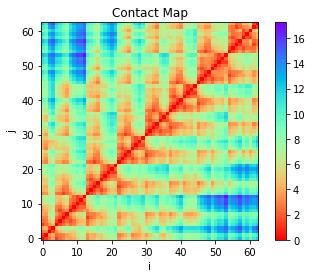

In [5]:
# Generate Contact Map
ct = tools.contact_map(pdb,ipdb,cols_removed,s_index)
ct_distal = tools.distance_restr(ct,s_index,make_large=True)
#--------------------------------------------------------------------#

plt.title('Contact Map')
plt.imshow(ct,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

tools.hide_toggle()

In [6]:
# find optimal threshold of distance for both DCA and ER
ct_thres = np.linspace(1.5,10.,18,endpoint=True)
n = ct_thres.shape[0]

#di_mf_dr = tools.distance_restr(di_mf,s_index,make_large=False)

auc_mf = np.zeros(n)

for i in range(n):
    p,tp,fp = tools.roc_curve(ct,di_mf,ct_thres[i])
    auc_mf[i] = tp.sum()/tp.shape[0]
    
i0_mf = np.argmax(auc_mf)

p0_mf,tp0_mf,fp0_mf = tools.roc_curve(ct,di_mf,ct_thres[i0_mf])

tools.hide_toggle()

### Plot the ROC curve

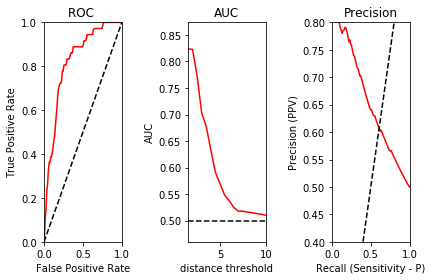

In [7]:
# Plot ROC for optimal DCA 

plt.subplot2grid((1,3),(0,0))
plt.title('ROC ')
plt.plot(fp0_mf,tp0_mf,'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Plot AUC for DCA and ER
plt.subplot2grid((1,3),(0,1))
plt.title('AUC')
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_mf,'r-')
plt.ylim([auc_mf.min()-0.05,auc_mf.max()+0.05])
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.xlabel('distance threshold')
plt.ylabel('AUC')

# Plot Precision of optimal DCA and ER
plt.subplot2grid((1,3),(0,2))
plt.title('Precision')
plt.plot( p0_mf,tp0_mf / (tp0_mf + fp0_mf),'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
#plt.ylim([0,1])
plt.ylim([.4,.8])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

plt.tight_layout(h_pad=1, w_pad=1.5)


tools.hide_toggle()

### Now we Restrain the problem to only consider contact map i, and j postitions st |i-j|<5

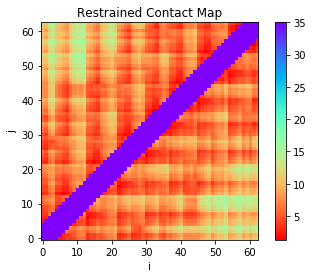

In [8]:
plt.title('Restrained Contact Map')
plt.imshow(ct_distal,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

auc_mf_DR = np.zeros(n)

tools.hide_toggle()

### Plot the ROC curve again
* Blocky ROC because of restrained system
    * Due to removal of TP from rates because of Distance constraint
    * Sequences where DI predicts many contacts between positions within 5 with have this block characteristic
* Increase in final AUC
* Precision is qualitatively un-changed

In [9]:
for i in range(n):
    p,tp,fp = tools.roc_curve(ct_distal,di_mf_dr,ct_thres[i])
    auc_mf_DR[i] = tp.sum()/tp.shape[0]
    
i0_mf_DR = np.argmax(auc_mf_DR)

p0_mf_DR,tp0_mf_DR,fp0_mf_DR = tools.roc_curve(ct_distal,di_mf_dr,ct_thres[i0_mf_DR])

tools.hide_toggle()

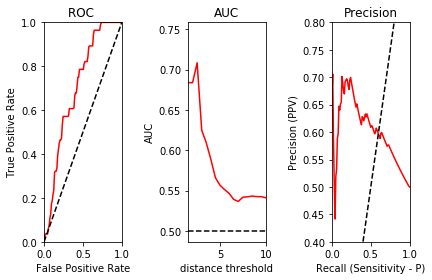

In [10]:
# Plot ROC for optimal DCA 

plt.subplot2grid((1,3),(0,0))
plt.title('ROC ')
plt.plot(fp0_mf_DR,tp0_mf_DR,'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Plot AUC for DCA and ER
plt.subplot2grid((1,3),(0,1))
plt.title('AUC')
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_mf_DR,'r-')
plt.ylim([auc_mf_DR.min()-0.05,auc_mf_DR.max()+0.05])
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.xlabel('distance threshold')
plt.ylabel('AUC')

# Plot Precision of optimal DCA and ER
plt.subplot2grid((1,3),(0,2))
plt.title('Precision')
plt.plot( p0_mf_DR,tp0_mf_DR / (tp0_mf_DR + fp0_mf_DR),'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
#plt.ylim([0,1])
plt.ylim([.4,.8])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

plt.tight_layout(h_pad=1, w_pad=1.5)


tools.hide_toggle()

### First plot the contact map and TP rate (PYDCA)
* Compare Sorted DIs (with and without distance restraint)
* No changes
    * PYDCA incorporates distance restrain in its plotting 

Dimensions of DI Pairs:
MF:  1953



	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


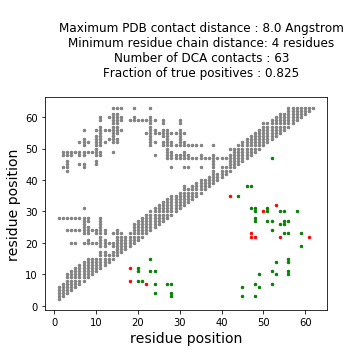


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


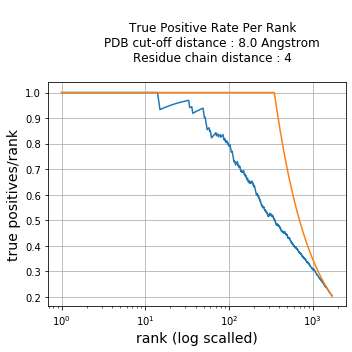

In [11]:
# Using PYDCA contact mapping module
print("Dimensions of DI Pairs:")
print("MF: ",len(sorted_DI_mf))

mfdca_visualizer_dr = contact_visualizer.DCAVisualizer('protein', pdb[ipdb,6], pdb[ipdb,5],
    refseq_file = ref_outfile,
    sorted_dca_scores = sorted_DI_mf_dr,
    linear_dist = 4,
    contact_dist = 8.0,
)

mf_contact_map_data = mfdca_visualizer_dr.plot_contact_map()

mf_tp_rate_data = mfdca_visualizer_dr.plot_true_positive_rates()

tools.hide_toggle()

Dimensions of DI Pairs:
MF:  1953



	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


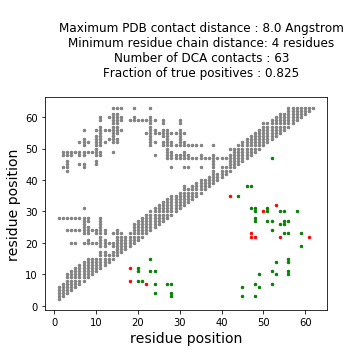


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


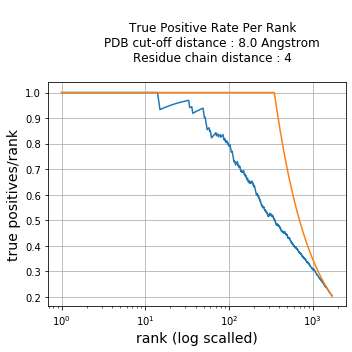

In [12]:
# Using PYDCA contact mapping module
print("Dimensions of DI Pairs:")
print("MF: ",len(sorted_DI_mf))

mfdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb[ipdb,6], pdb[ipdb,5],
    refseq_file = ref_outfile,
    sorted_dca_scores = sorted_DI_mf,
    linear_dist = 4,
    contact_dist = 8.0,
)

mf_contact_map_data = mfdca_visualizer.plot_contact_map()

mf_tp_rate_data = mfdca_visualizer.plot_true_positive_rates()

tools.hide_toggle()

## Conclusion
* Adding distance constraint can remove some TPs along diagonal
    * As defined through contact map with given threshold
    * These TP along the diagonal would should not be considered anyways. 
    * When comparing to actual Structure data (using PYDCA) there is little/no change
* The Blocked-ROC curve phenomena after adding distance constraint only appears in certain Proteins
    * PF00011 &rarr; Blocky ROC after distance restraint
    * PF04542 &rarr; Smooth ROC after distance restraint
    * Likely artifact of the data being considered.
    